### 📝 Project Introduction
Drone Detection using YOLOv5

In this project, iam going to train a drone dataset already annotated from kaggle [link](https://www.kaggle.com/datasets/sshikamaru/drone-yolo-detection), this data contanos 4000 annotated image i will split it into 3100, 700, 200 for trian, val, test using YOLO V5 achiving 0.898 Percision, 0.872 recall, 0.933 MAP50, 0.925 MAP50-95.

So lets get into it.

## Fetching the data
Fetching the data from kaggle(you can skip it if you already on kaggle)

In [1]:
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sshikamaru/drone-yolo-detection

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/drone-yolo-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 95% 150M/157M [00:00<00:00, 1.57GB/s]
100% 157M/157M [00:00<00:00, 1.55GB/s]


In [ ]:
!unzip drone-yolo-detection -d dataset/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Database1/Database1/video17_1031.JPEG  
  inflating: dataset/Database1/Database1/video17_1031.txt  
  inflating: dataset/Database1/Database1/video17_1032.JPEG  
  inflating: dataset/Database1/Database1/video17_1032.txt  
  inflating: dataset/Database1/Database1/video17_1033.JPEG  
  inflating: dataset/Database1/Database1/video17_1033.txt  
  inflating: dataset/Database1/Database1/video17_1034.JPEG  
  inflating: dataset/Database1/Database1/video17_1034.txt  
  inflating: dataset/Database1/Database1/video17_1035.JPEG  
  inflating: dataset/Database1/Database1/video17_1035.txt  
  inflating: dataset/Database1/Database1/video17_1036.JPEG  
  inflating: dataset/Database1/Database1/video17_1036.txt  
  inflating: dataset/Database1/Database1/video17_1037.JPEG  
  inflating: dataset/Database1/Database1/video17_1037.txt  
  inflating: dataset/Database1/Database1/video17_104.JPEG  
  inflating: dataset/Database1/Database1/v

## Step 1: Data Preparation

In this step, we prepare the data and split it before training

Before running anything, we need to install the required libraries

In [ ]:
!pip install -r requirements.txt

Import the main Python libraries needed for data preparation.

In [ ]:
import os
import random
import shutil

After downloading the data this is its stucture  
Datasets/  
└── Database1/  
    ├── image1.JPEG training image  
    ├── image1.TXT  annotation  


We need to split it for train, val, and test folders with their annotations

In [ ]:
#Assign dataset dir and the train, val, test dir to be created in
data_dir = '/content/dataset/Database1/Database1'
train_dir = '/content/process/data/train'
val_dir = '/content/process/data/val'
test_dir = '/content/process/data/test'

#Make new dir for traing, Val, test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
#Get only the files ends with ('.JPEG') the trainig images only and assign to files variable
files = [f for f in os.listdir(data_dir) if f.endswith('.JPEG')]

#Shuffle the images
random.shuffle(files)

In [ ]:
#Gets 3100, 700 and 200 for train,val, test
train_files = files[:3100]
val_files = files[3100:3800]
test_files = files[3800:]

A Function that fetchs the annotation txt file for each image and put (image1.JPEG, image1.TXT) in the same train, val, test folder  
And checks if theres a missing annotation for an image  

In [ ]:
def move_files(file_list, source_dir, dest_dir):
    for file_name in file_list:
        base_name = os.path.splitext(file_name)[0]
        image_path = os.path.join(source_dir, file_name)
        annotation_path = os.path.join(source_dir, base_name + '.txt')

        if os.path.exists(image_path) and os.path.exists(annotation_path):
            shutil.copy(image_path, dest_dir)
            shutil.copy(annotation_path, dest_dir)
        else:
            print(f"Skipping {base_name} due to missing file")

move_files(train_files, data_dir, train_dir)
move_files(val_files, data_dir, val_dir)
move_files(test_files, data_dir, test_dir)

Skipping video15_487 due to missing file
Skipping video18_1999 due to missing file


Now the data is all set and ready for training

In [ ]:
#Prints the length of each folder divided by 2 to skip the annotation
print("Training set size:", len(os.listdir(train_dir)) // 2)
print("Validation set size:", len(os.listdir(val_dir)) // 2)
print("Test set size:", len(os.listdir(test_dir)) // 2)

Training set size: 3099
Validation set size: 700
Test set size: 211


## Step 2: Training  


Now, let's clone the Yolo v5 repo from ultralytics and enter it

In [1]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17608, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17608 (delta 7), reused 2 (delta 2), pack-reused 17593 (from 2)
Receiving objects: 100% (17608/17608), 16.84 MiB | 14.15 MiB/s, done.
Resolving deltas: 100% (11991/11991), done.


Install the required dependencies for training

In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.0 MB/s eta 0:00:00


In YOLO V5, we need to create a YAML file that contains the path folder for train, val, and test data, and the no of classes and class names

In [ ]:
!echo "train: /content/process/data/train" > drone_data.yaml
!echo "val: /content/process/data/val" >> drone_data.yaml
!echo "test: /content/process/data/test" >> drone_data.yaml
!echo "nc: 1" >> drone_data.yaml
!echo "names: ['drone']" >> drone_data.yaml

let's make sure we're in YOLO v5 repo

In [ ]:
%cd /content/yolov5

/content/yolov5


Now, let's start training this command run training script that takes hyperparameters:  
image size  
batch   
epochs  
YAML file we created  
Choose config file for the model and pretrained weights

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data drone_data.yaml --cfg yolov5s.yaml --weights yolov5s.pt

Streaming output truncated to the last 5000 lines.
      37/49      4.51G    0.02957   0.005953          0         25        640:  30% 59/194 [00:25<00:50,  2.69it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      37/49      4.51G    0.02956   0.005959          0         28        640:  31% 60/194 [00:26<00:53,  2.50it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      37/49      4.51G    0.02957   0.005973          0         27        640:  31% 61/194 [00:26<00:48,  2.76it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      37/49      4.51G    0.02958 

Now, let's try the model on one object

YOLOv5 🚀 v7.0-440-gf5ebc52c Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


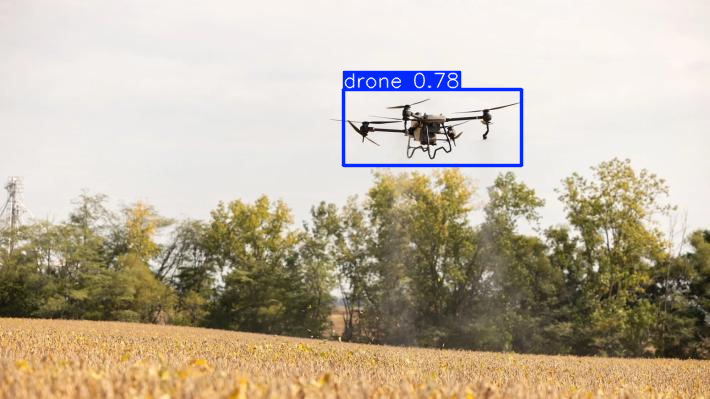

In [9]:
import torch

# Load the model
model = torch.hub.load('/content/yolov5', 'custom', path='/content/best.pt', source='local')

# Test with a single image
img = '/content/Drone_1.jpg'
results = model(img)
results.show()

And with multiple objects

YOLOv5 🚀 v7.0-440-gf5ebc52c Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


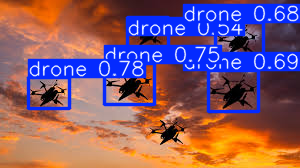

In [ ]:
import torch

# Load the model
model = torch.hub.load('/content/yolov5', 'custom', path='/content/best.pt', source='local')

# Test with a single image
img = '/content/Drones.jpeg'
results = model(img)
results.show()

### Note:  
This is the YOLO v5 small model. If I used a larger one, the precision would be better, but the small one has solid results and fast.